# Edge Prediction

This notebook creates a graph with nodes labeled by the lexicon terms and stores the document vectors as node features. It then predicts existence of the edges based on the similarity of node features.

More specifically, we use KL-divergence distance of two multivariate normal distributions of respective nodes features as the edge weights.

Here is the steps we will take:

- load and group GPT-3 topic-embeddings of the PubMed documents.
- Fit multivariate normal distributions to the node features (loc and diagonal_scale).
- Calculate the adjacency matrix using KL-divergence of the node features.

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix
from sklearn.preprocessing import normalize
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

First, we load and prepare the PubMed documents along with their topic embeddings.

In [23]:
# load weights, clusters and metadata (takes ~ 20sec)

clusters = pd.read_csv('models/gpt3/abstracts_gpt3ada_clusters.csv.gz', index_col=0)
weights = np.load('models/gpt3/abstracts_gpt3ada_weights.npz')['arr_0']
clusters['weights'] = list(weights)

# load abstracts
pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=False).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

print(f'Successfully create a list of {len(pubmed)} topic-embeddings.')

Successfully create a list of 293014 topic-embeddings.


In [52]:
# discard low-occurred labels

docs_per_label = pubmed.groupby('label').size()
low_appeared_labels = docs_per_label[docs_per_label < 5].index.to_list()

pubmed = pubmed.query('label not in @low_appeared_labels')

print(f'Successfully removed {len(low_appeared_labels)} low-appeared labels.')

Successfully removed 14 low-appeared labels.


## Node-node similarity

Here, we calculate the similarity between nodes using the node features. We use
KL-divergence of the node features a measure of distance between the two.

In [139]:
def find_category_by_label(label, pubmed=pubmed):
  return pubmed.query('label == @label')['category'].iloc[0]


def nll(X, dist):
  return - tf.reduce_mean(dist.log_prob(X))


@tf.function
def get_loss_and_grads(X_train, dist):
  with tf.GradientTape() as tape:
    tape.watch(dist.trainable_variables)
    loss = nll(X_train, dist)
  grads = tape.gradient(loss, dist.trainable_variables)
  return loss, grads

def fit_multivariate_normal(data, n_epochs=100, batch_size=1000):
  dist = tfd.MultivariateNormalDiag(
    loc=tf.Variable(data.mean(axis=0), name='loc'),
    scale_diag=tf.Variable(np.ones(data.shape[1]), name='scale_diag'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

  for _ in range(n_epochs):
    # for batch in np.array_split(data, 1 + (data.shape[0] // batch_size)):
    batch = data  # use all the data in each epoch
    loss, grads = get_loss_and_grads(batch, dist)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    # loc_value = dist.loc.value()
  return dist

tqdm.pandas()

# node distributions
node_dists = pubmed.groupby('label')['weights'].progress_apply(
  lambda docs: fit_multivariate_normal(np.stack(docs))
)

# n2n_dists.index = n2n_sim.index.droplevel(level=1)
# n2n_dists.columns = n2n_sim.columns.droplevel(level=1)

# cache the node-to-node kl distance matrix
n2n_kl = np.zeros((len(node_dists), len(node_dists)))

for i,lbl_i in tqdm(enumerate(node_dists.index)):
  for j, lbl_j in enumerate(node_dists.index):
    kl = node_dists.loc[lbl_i].kl_divergence(node_dists.loc[lbl_j]).numpy()
    n2n_kl[i,j] = kl

n2n_kl = pd.DataFrame(n2n_kl, index=node_dists.index, columns=node_dists.index)
n2n_kl

100%|██████████| 156/156 [6:40:05<00:00, 153.88s/it]    
156it [5:34:55, 128.82s/it]


label,AnalogyMakingTask,AntiSaccadeTask,Attention,AttentionNetworkTest,AttentionalControl,AttentionalInertia,AuditoryAttentionTask,AutomatedOperationSpanTask,BART,BalanceBeamTask,...,Updating,VerbalProcessing,VerbalWorkingMemory,Verbal_fluency_task,VisuospatialProcessing,VisuospatialSketchpad,VisuospatialWorkingMemory,Volition,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory
label,,,,,,,,,,,,,,,,,,,,,
AnalogyMakingTask,0.000000,22213.734576,8103.422165,8307.098051,12443.963162,38932.023199,6642.046091,7.311929e+05,13514.605150,46624.782375,...,15215.577247,22735.417175,335010.856579,84462.870830,5216.537462,99118.094161,35837.385054,16836.789915,87162.960907,20811.414453
AntiSaccadeTask,270405.868301,0.000000,7570.685075,10661.124324,23806.781859,59590.173961,7448.665702,1.549503e+06,8392.772191,34981.329042,...,31179.640832,27650.892205,37076.318833,36800.350057,9175.445511,15930.071535,57812.365075,17992.874813,160636.902566,11771.200173
Attention,303749.010076,10294.183352,0.000000,4876.115392,15961.303899,23824.198687,2863.479787,3.940737e+05,14073.770875,10920.243865,...,16773.067485,29479.176218,58665.891034,21349.847493,2971.419898,23414.589956,22145.544197,5987.902294,36518.924934,9546.354529
AttentionNetworkTest,353993.947651,41917.527832,7671.548078,0.000000,21785.937947,63822.677008,5825.142275,4.969286e+05,18053.323316,34827.909420,...,41815.605147,84009.704588,291368.240441,88374.696400,8654.148227,237971.601042,46160.009892,10159.331189,40595.856375,29392.428619
AttentionalControl,247232.910604,17864.216989,5881.184586,6872.540912,0.000000,25575.415653,6565.583075,1.291673e+06,15527.910388,5763.054046,...,21142.106243,47496.901185,119709.137230,16066.147072,7645.641264,257587.728553,66921.731643,3989.261170,54594.014368,21164.134634
AttentionalInertia,144842.245296,74190.048164,9074.679805,12837.767779,15386.947367,0.000000,6025.917540,1.295239e+06,11237.966421,28381.309790,...,37351.674863,111186.829520,131690.601871,45918.424285,11527.200204,132613.410349,44790.556828,11377.005973,17882.104615,22372.551927
AuditoryAttentionTask,144578.414968,53866.058334,10051.752652,17073.101978,24025.167416,59508.563510,0.000000,1.340541e+06,18628.753191,35129.481663,...,54086.995603,21649.811039,289744.749492,31381.982357,6921.452129,173399.091356,79430.863261,15587.738252,12261.806789,17326.062263
AutomatedOperationSpanTask,471160.374638,53565.749624,9189.663030,7500.245024,25414.608008,44654.015213,5956.990839,0.000000e+00,15459.049109,40573.245537,...,52970.770929,19457.483974,327818.648985,35738.421650,8778.874534,155220.490936,29378.254559,13078.399360,7210.159312,23881.942227
BART,14012.673164,47588.802197,10173.621410,4150.206217,17908.062705,33084.914127,3744.222723,6.109490e+04,0.000000,21164.345028,...,36383.531263,41048.921331,221882.458140,15726.718834,9398.843314,316893.124886,41977.489908,10260.546346,39755.632798,21267.790553


In [140]:
vmax = np.median(n2n_kl.values.flatten()) + np.std(n2n_kl.values.flatten())
vmin = np.median(n2n_kl.values.flatten()) - np.std(n2n_kl.values.flatten())

x = n2n_kl.values
x = np.where(x > vmax , np.nan, x)
x = np.where(x < vmin, np.nan, x)
n2n_kl.iloc[:,:] = x
n2n_kl

label,AnalogyMakingTask,AntiSaccadeTask,Attention,AttentionNetworkTest,AttentionalControl,AttentionalInertia,AuditoryAttentionTask,AutomatedOperationSpanTask,BART,BalanceBeamTask,...,Updating,VerbalProcessing,VerbalWorkingMemory,Verbal_fluency_task,VisuospatialProcessing,VisuospatialSketchpad,VisuospatialWorkingMemory,Volition,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory
label,,,,,,,,,,,,,,,,,,,,,
AnalogyMakingTask,0.000000,22213.734576,8103.422165,8307.098051,12443.963162,38932.023199,6642.046091,7.311929e+05,13514.605150,46624.782375,...,15215.577247,22735.417175,335010.856579,84462.870830,5216.537462,99118.094161,35837.385054,16836.789915,87162.960907,20811.414453
AntiSaccadeTask,270405.868301,0.000000,7570.685075,10661.124324,23806.781859,59590.173961,7448.665702,1.549503e+06,8392.772191,34981.329042,...,31179.640832,27650.892205,37076.318833,36800.350057,9175.445511,15930.071535,57812.365075,17992.874813,160636.902566,11771.200173
Attention,303749.010076,10294.183352,0.000000,4876.115392,15961.303899,23824.198687,2863.479787,3.940737e+05,14073.770875,10920.243865,...,16773.067485,29479.176218,58665.891034,21349.847493,2971.419898,23414.589956,22145.544197,5987.902294,36518.924934,9546.354529
AttentionNetworkTest,353993.947651,41917.527832,7671.548078,0.000000,21785.937947,63822.677008,5825.142275,4.969286e+05,18053.323316,34827.909420,...,41815.605147,84009.704588,291368.240441,88374.696400,8654.148227,237971.601042,46160.009892,10159.331189,40595.856375,29392.428619
AttentionalControl,247232.910604,17864.216989,5881.184586,6872.540912,0.000000,25575.415653,6565.583075,1.291673e+06,15527.910388,5763.054046,...,21142.106243,47496.901185,119709.137230,16066.147072,7645.641264,257587.728553,66921.731643,3989.261170,54594.014368,21164.134634
AttentionalInertia,144842.245296,74190.048164,9074.679805,12837.767779,15386.947367,0.000000,6025.917540,1.295239e+06,11237.966421,28381.309790,...,37351.674863,111186.829520,131690.601871,45918.424285,11527.200204,132613.410349,44790.556828,11377.005973,17882.104615,22372.551927
AuditoryAttentionTask,144578.414968,53866.058334,10051.752652,17073.101978,24025.167416,59508.563510,0.000000,1.340541e+06,18628.753191,35129.481663,...,54086.995603,21649.811039,289744.749492,31381.982357,6921.452129,173399.091356,79430.863261,15587.738252,12261.806789,17326.062263
AutomatedOperationSpanTask,471160.374638,53565.749624,9189.663030,7500.245024,25414.608008,44654.015213,5956.990839,0.000000e+00,15459.049109,40573.245537,...,52970.770929,19457.483974,327818.648985,35738.421650,8778.874534,155220.490936,29378.254559,13078.399360,7210.159312,23881.942227
BART,14012.673164,47588.802197,10173.621410,4150.206217,17908.062705,33084.914127,3744.222723,6.109490e+04,0.000000,21164.345028,...,36383.531263,41048.921331,221882.458140,15726.718834,9398.843314,316893.124886,41977.489908,10260.546346,39755.632798,21267.790553


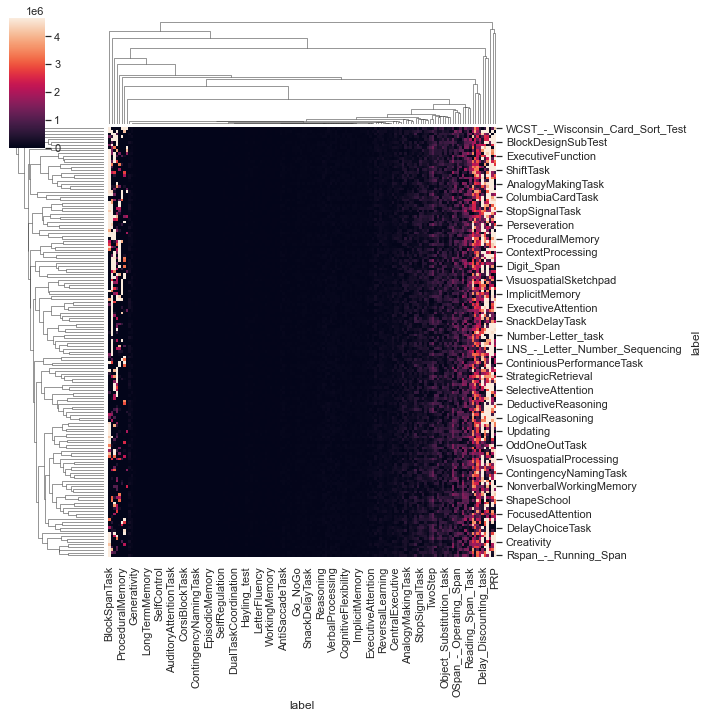

In [141]:
# plot distance matrix of all the node pairs

node_features = n2n_kl

# add node types (task or construct)
# node_features['category'] = node_features.index.to_series().apply(find_category_by_label)
# node_features.set_index(['category'], append=True, inplace=True)

sns.clustermap(node_features.fillna(0), robust=True)

In [142]:
# visualize the similarity between constructs pairs regardless of the underlying tasks

# # drop tasks for visualization
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
plot_data = n2n_kl.drop(index=tasks, columns=tasks)

# # heatmap plot categorized by label category, either task or construct
# g = sns.clustermap(labels_sim,
#                    figsize=(25, 25),
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    robust=True)
# plt.show()

dashbio.Clustergram(
  data=plot_data.fillna(0),
  column_labels=plot_data.columns.to_list(),
  row_labels=plot_data.index.to_list(),
  cluster='all',
  center_values=False,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)


## Popular Constructs

In [ ]:
# plot only popular tasks and popular constructs

n_popular_labels = 40

popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())

popular_label_embeddings = n2n_kl.query('label in @popular_labels')

popular_labels_kl = get_similarity_matrix(
  popular_label_embeddings,
  metric='cosine',
  pivot_by_category=False)

# # drop tasks for visualization
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
popular_labels_kl.drop(index=tasks, columns=tasks, errors='ignore', inplace=True)

# g = sns.clustermap(popular_labels_sim, robust=True,
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    cmap='viridis_r',
#                   )
# plt.show()

import dash_bio as dashbio

dashbio.Clustergram(
  data=popular_labels_kl,
  column_labels=popular_labels_kl.columns.to_list(),
  row_labels=popular_labels_kl.index.to_list(),
  center_values=False,
  cluster='all',
  height=800,
  width=900,
  display_ratio=[0.001, 0.001], 
  color_map='RdBu_r',
  # hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)

In [ ]:
# plot kl-divergence between construct labels, ignoring the task labels.

X = popular_label_embeddings.query('category.str.contains("Construct")')
X_sim = get_similarity_matrix(X, metric='cosine', pivot_by_category=False)

sns.set('poster')
g = sns.clustermap(X_sim,figsize=(22,20), dendrogram_ratio=0.0001,
               cbar_pos=(1.0, 0.73, 0.03, 0.25),
               cmap='RdBu_r', cbar_kws={'label': 'cosine similarity'})
g.ax_heatmap.set(xlabel='Construct', ylabel='Construct')
plt.suptitle('Cosine similarity between most popular constructs',y=1.01)
plt.show()

In [19]:
# create a graph

import stellargraph as sg
from stellargraph.data import UniformRandomMetaPathWalk

embeddings = popular_label_embeddings

sim = get_similarity_matrix(embeddings, metric='kl', pivot_by_category=False)
sim.columns.name = 'source'
sim.index.name = 'target'

# keep = np.triu(np.ones(sim.shape)).astype('bool').reshape(sim.size)
adj = sim.stack().to_frame().reset_index().rename(columns={0: 'weight'})

adj = adj.query('target != source')

# use separate filtering for each of the edge types
edge_threshold = adj['weight'].median() + adj['weight'].std()

edges = adj.query('weight >= @edge_threshold')

constructs = embeddings.query('category == "CognitiveConstruct"').reset_index(1,drop=True)
tasks = embeddings.query('category == "CognitiveTask"').reset_index(1,drop=True)

G = sg.StellarGraph(
  nodes = {'task': tasks,
           'construct': constructs},
  edges=edges)
print(G.info())

2022-01-21 18:10:31.940359: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


StellarGraph: Undirected multigraph
 Nodes: 170, Edges: 1098

 Node types:
  task: [98]
    Features: float32 vector, length 509
    Edge types: task-default->construct, task-default->task
  construct: [72]
    Features: float32 vector, length 509
    Edge types: construct-default->construct, construct-default->task

 Edge types:
    construct-default->task: [542]
        Weights: range=[1.42376, 3.64397], mean=1.85238, std=0.505267
        Features: none
    task-default->task: [480]
        Weights: range=[1.42983, 3.69662], mean=1.97829, std=0.539378
        Features: none
    construct-default->construct: [76]
        Weights: range=[1.4276, 1.78699], mean=1.53227, std=0.0938251
        Features: none


In [9]:
# metapath2vec

from gensim.models import Word2Vec

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

walks = UniformRandomMetaPathWalk(G).run(
    nodes=list(G.nodes()),  # root nodes
    length=3,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
print(f'[MetaPath2Vec] Created {len(walks)} random walks.')
# DEBUG: print('Random walks starting from the "RewardProcessing" node:',
# DEBUG:      [' -> '.join(w) for w in walks if w[0] == 'RewardProcessing'])

print('[MetaPath2Vec] Now training the Word2Vec model...', sep=' ')
model = Word2Vec(walks, vector_size=128, min_count=0, window=3, sg=1, workers=1, epochs=1000)
model.save('models/gpt3/abstracts_metapath2vec.pkl')

print('[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.')

[MetaPath2Vec] Created 1700 random walks.
[MetaPath2Vec] Now training the Word2Vec model...
[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.


In [10]:
# query the joint graph

from gensim.models import Word2Vec
model = Word2Vec.load('models/gpt3/abstracts_metapath2vec.pkl')

#  visual-spatial and organizational processing abilities, as well as nonverbal problem-solving skills. 
 
# FIXME: there is a typo in "CogntiveControl"; it comes from a type in the original lexicon.
model.wv.most_similar(
  positive=['ReversalLearning', 'RewardProcessing'],
  negative=['Sorting_task','Go_NoGo'],
  topn=20)

# TODO filter by category


[('MotivationalDrive', 0.21943780779838562),
 ('BART', 0.1906529664993286),
 ('FeedbackLearning', 0.1432102918624878),
 ('GiftDelay', 0.08712416887283325),
 ('InformationSampling', 0.0826907828450203),
 ('BehavioralControl', 0.08228850364685059),
 ('BalanceBeamTask', 0.07746300101280212),
 ('StimSSS', 0.06688535958528519),
 ('PurposiveAction', 0.04619359225034714),
 ('ShiftTask', 0.02688433602452278),
 ('Flexibility_Test', 0.02671627327799797),
 ('ImplicitMemory', 0.026621967554092407),
 ('AutomatedOperationSpanTask', 0.021053258329629898),
 ('ProceduralMemory', 0.01954764500260353),
 ('ExplicitMemory', 0.018486469984054565),
 ('CogntiveControl', 0.016461219638586044),
 ('Inhibition', 0.016195109114050865),
 ('StopSignalTask', 0.007425000425428152),
 ('Binding', 0.0028698418755084276),
 ('SelfMonitoring', 0.001022959710098803)]

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


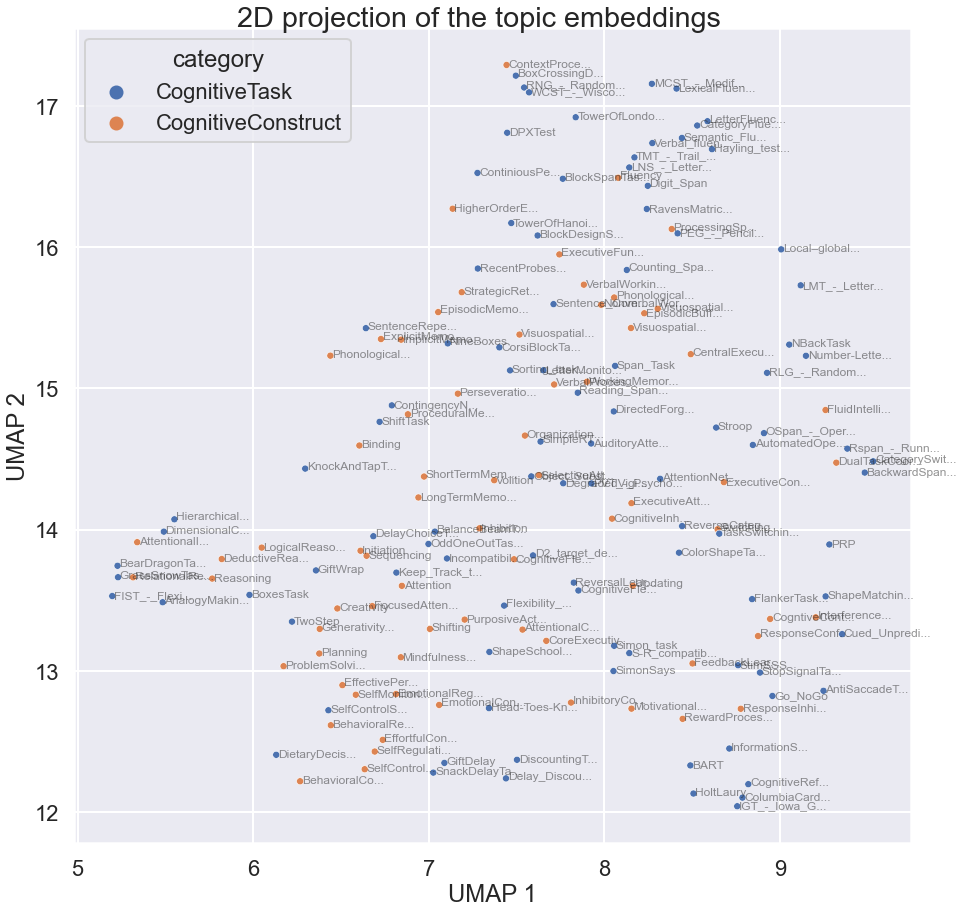

In [14]:
# Plot all tasks and constructs in a lower dimensional 3d space

import plotly.express as px

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections_3d = UMAP(n_components=3, random_state=0).fit_transform(popular_label_embeddings)
projections_2d = UMAP(n_components=2, random_state=0).fit_transform(label_embeddings)

projections_3d = pd.DataFrame(projections_3d, index=popular_label_embeddings.index).reset_index()
projections_2d = pd.DataFrame(projections_2d, index=label_embeddings.index).reset_index()

fig = px.scatter_3d(projections_3d,
                    x=0, y=1, z=2,
                    color='category', hover_name='label',
                    title='Popular labels in the topic space',
                    color_discrete_sequence=['red','blue'],
                    width=600, height=600,)
fig.show()


fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.scatterplot(data=projections_2d, x=0, y=1, ax=ax, s=50, hue='category')

for (i,lbl, _,x, y) in projections_2d.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=12)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

In [15]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,scikit-learn,python.cogtext

Last updated: 2022-01-21T16:09:50.086463+01:00

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

umap          : 0.5.2
pytorch       : not installed
scikit-learn  : 0.0
python.cogtext: 0.1.2022012116

plotly      : 5.3.1
seaborn     : 0.11.2
pandas      : 1.3.4
dash_bio    : 0.8.0
numpy       : 1.20.3
sys         : 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:38:53) 
[Clang 11.1.0 ]
matplotlib  : 3.4.3
stellargraph: 1.2.1

